# CNN — FashionMNIST Classification (PyTorch)
A convolutional neural network trained on FashionMNIST. Covers data loading, augmentation, architecture design, training with early stopping, and evaluation with a confusion matrix and per-class metrics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 1. Load & Explore Data

In [2]:
CLASS_NAMES = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Mean and std computed from FashionMNIST training set
MEAN, STD = 0.2860, 0.3530

# Train: random flip + crop + normalization (data augmentation)
# Val/Test: normalization only
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[MEAN], std=[STD])
])

eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[MEAN], std=[STD])
])

# Download dataset
full_train = datasets.FashionMNIST(root='./data', train=True,  download=True, transform=train_transform)
test_set   = datasets.FashionMNIST(root='./data', train=False, download=True, transform=eval_transform)

# Split train -> train + val (85% / 15%)
val_size   = int(0.15 * len(full_train))
train_size = len(full_train) - val_size
train_set, val_set = random_split(full_train, [train_size, val_size],
                                   generator=torch.Generator().manual_seed(42))

# Apply eval transform to val (no augmentation)
val_set.dataset.transform = eval_transform

print(f'Train: {len(train_set):,} | Val: {len(val_set):,} | Test: {len(test_set):,}')
print(f'Classes: {CLASS_NAMES}')

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 222kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.16MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.16MB/s]

Train: 51,000 | Val: 9,000 | Test: 10,000
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## 2. Visualize Samples

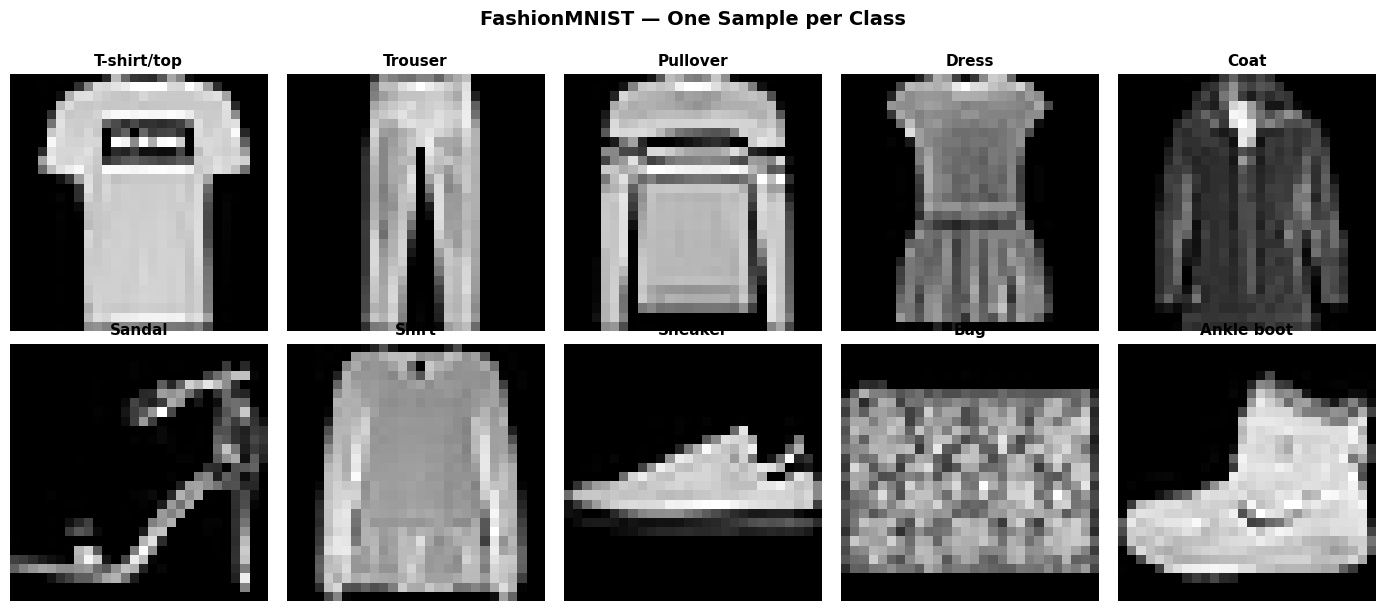

In [3]:
# Use raw (un-normalized) data for display only
raw_set = datasets.FashionMNIST(root='./data', train=True, download=False,
                                  transform=transforms.ToTensor())

fig, axes = plt.subplots(2, 5, figsize=(14, 6))
for i, ax in enumerate(axes.flat):
    idx = next(j for j, (_, y) in enumerate(raw_set) if y == i)
    img, label = raw_set[idx]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(CLASS_NAMES[label], fontsize=11, fontweight='bold')
    ax.axis('off')

plt.suptitle('FashionMNIST — One Sample per Class', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## 3. DataLoaders

In [4]:
BATCH_SIZE = 64

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

X_batch, y_batch = next(iter(train_loader))
print(f'Batch input shape : {X_batch.shape}')   # (64, 1, 28, 28)
print(f'Batch label shape : {y_batch.shape}')   # (64,)

Batch input shape : torch.Size([64, 1, 28, 28])
Batch label shape : torch.Size([64])


## 4. CNN Architecture

Two convolutional blocks followed by a fully connected classifier head.

```
Input  (1, 28, 28)
  -> Conv2d(1->32, 3x3, pad=1) + BN + ReLU + MaxPool(2x2)   -> (32, 14, 14)
  -> Conv2d(32->64, 3x3, pad=1) + BN + ReLU + MaxPool(2x2)  -> (64, 7, 7)
  -> Flatten                                                  -> 3136
  -> Linear(3136->256) + BN + ReLU + Dropout(0.4)
  -> Linear(256->10)   [raw logits]
```

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10, dropout=0.4):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)        # 28x28 -> 14x14
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)        # 14x14 -> 7x7
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                      # 64 * 7 * 7 = 3136
            nn.Linear(64 * 7 * 7, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)        # raw logits
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        return self.classifier(x)


model = CNN(num_classes=10, dropout=0.4).to(device)

total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters    : {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(model)


""" You can define everything as a single block, it is rather conventional so separate the network by parts.
self.network = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10)
)
"""

Total parameters    : 825,162
Trainable parameters: 825,162
CNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.4, inplace=False)
    (5): Linear(in_features=256, out_features=10, bias=True)
  )

## 5. Training with Early Stopping

In [6]:
EPOCHS   = 30
LR       = 1e-3
PATIENCE = 5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []
best_val_loss    = float('inf')
best_state       = None
patience_counter = 0

for epoch in range(1, EPOCHS + 1):

    # -- Train --
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss   = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(X)
        correct      += (logits.argmax(1) == y).sum().item()
        total        += len(X)

    train_loss = running_loss / total
    train_acc  = correct / total

    # -- Validate --
    model.eval()
    v_loss, v_correct, v_total = 0.0, 0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            logits   = model(X)
            v_loss   += criterion(logits, y).item() * len(X)
            v_correct += (logits.argmax(1) == y).sum().item()
            v_total  += len(X)

    val_loss = v_loss / v_total
    val_acc  = v_correct / v_total

    scheduler.step(val_loss)
    train_losses.append(train_loss); val_losses.append(val_loss)
    train_accs.append(train_acc);   val_accs.append(val_acc)

    # -- Early stopping --
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state    = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1

    print(f'Epoch {epoch:3d}/{EPOCHS} | '
          f'Train Loss: {train_loss:.4f}  Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f}  Acc: {val_acc:.4f}')

    if patience_counter >= PATIENCE:
        print(f'\nEarly stopping at epoch {epoch} (no improvement for {PATIENCE} epochs)')
        break

model.load_state_dict(best_state)
print(f'\nBest val loss: {best_val_loss:.4f}')

c:\Users\felip\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch   1/30 | Train Loss: 0.3647  Acc: 0.8711 | Val Loss: 0.2839  Acc: 0.8992
Epoch   2/30 | Train Loss: 0.2522  Acc: 0.9082 | Val Loss: 0.2335  Acc: 0.9156
Epoch   3/30 | Train Loss: 0.2163  Acc: 0.9220 | Val Loss: 0.2221  Acc: 0.9210
Epoch   4/30 | Train Loss: 0.1926  Acc: 0.9286 | Val Loss: 0.2287  Acc: 0.9170
Epoch   5/30 | Train Loss: 0.1750  Acc: 0.9363 | Val Loss: 0.2077  Acc: 0.9227
Epoch   6/30 | Train Loss: 0.1572  Acc: 0.9420 | Val Loss: 0.2185  Acc: 0.9226
Epoch   7/30 | Train Loss: 0.1460  Acc: 0.9461 | Val Loss: 0.2302  Acc: 0.9184
Epoch   8/30 | Train Loss: 0.1328  Acc: 0.9505 | Val Loss: 0.2369  Acc: 0.9156
Epoch   9/30 | Train Loss: 0.1247  Acc: 0.9542 | Val Loss: 0.2178  Acc: 0.9249
Epoch  10/30 | Train Loss: 0.0831  Acc: 0.9710 | Val Loss: 0.2056  Acc: 0.9303
Epoch  11/30 | Train Loss: 0.0699  Acc: 0.9757 | Val Loss: 0.2298  Acc: 0.9263
Epoch  12/30 | Train Loss: 0.0622  Acc: 0.9782 | Val Loss: 0.2290  Acc: 0.9294
Epoch  13/30 | Train Loss: 0.0556  Acc: 0.9803 | Val

## 6. Training Curves

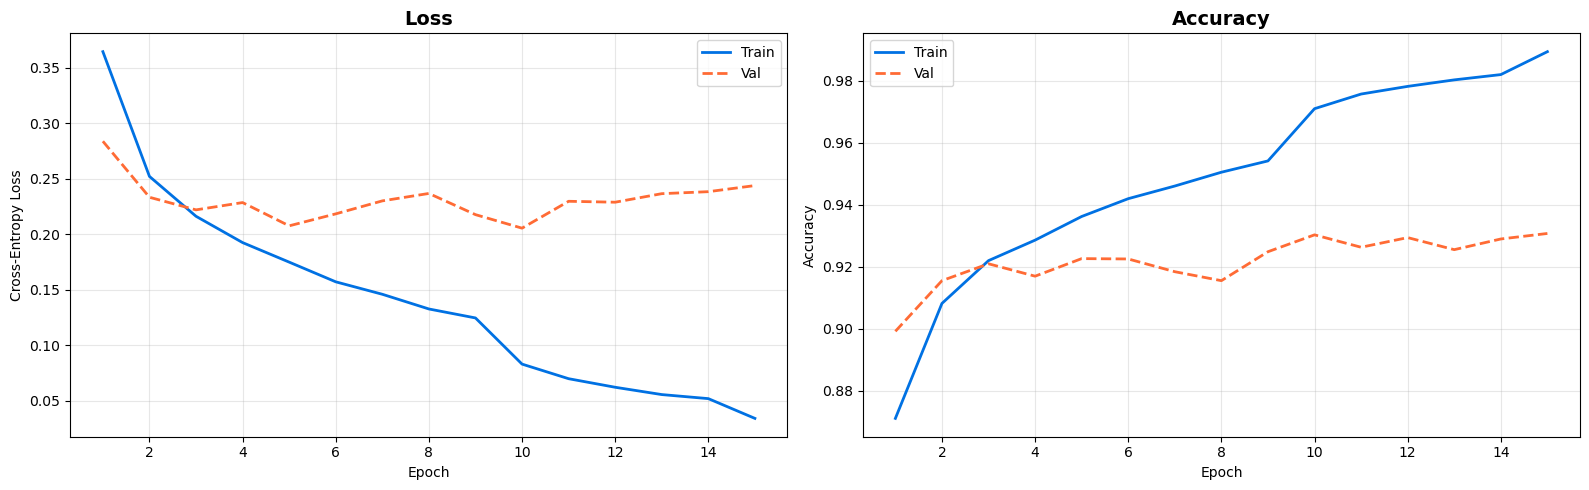

In [7]:
epochs_ran = range(1, len(train_losses) + 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(epochs_ran, train_losses, label='Train', color='#0071e3', linewidth=2)
axes[0].plot(epochs_ran, val_losses,   label='Val',   color='#ff6b35', linewidth=2, linestyle='--')
axes[0].set_title('Loss',     fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Cross-Entropy Loss')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_ran, train_accs, label='Train', color='#0071e3', linewidth=2)
axes[1].plot(epochs_ran, val_accs,   label='Val',   color='#ff6b35', linewidth=2, linestyle='--')
axes[1].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Test Set Evaluation

In [8]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X, y in test_loader:
        X    = X.to(device)
        preds = model(X).argmax(dim=1).cpu()
        all_preds.append(preds)
        all_labels.append(y)

all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

test_acc = (all_preds == all_labels).mean()
print(f'Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)\n')
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

Test Accuracy: 0.9243 (92.43%)

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.88      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.88      0.91      0.89      1000
       Dress       0.91      0.93      0.92      1000
        Coat       0.89      0.87      0.88      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.79      0.76      0.77      1000
     Sneaker       0.97      0.97      0.97      1000
         Bag       0.98      0.99      0.99      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



## 8. Confusion Matrix

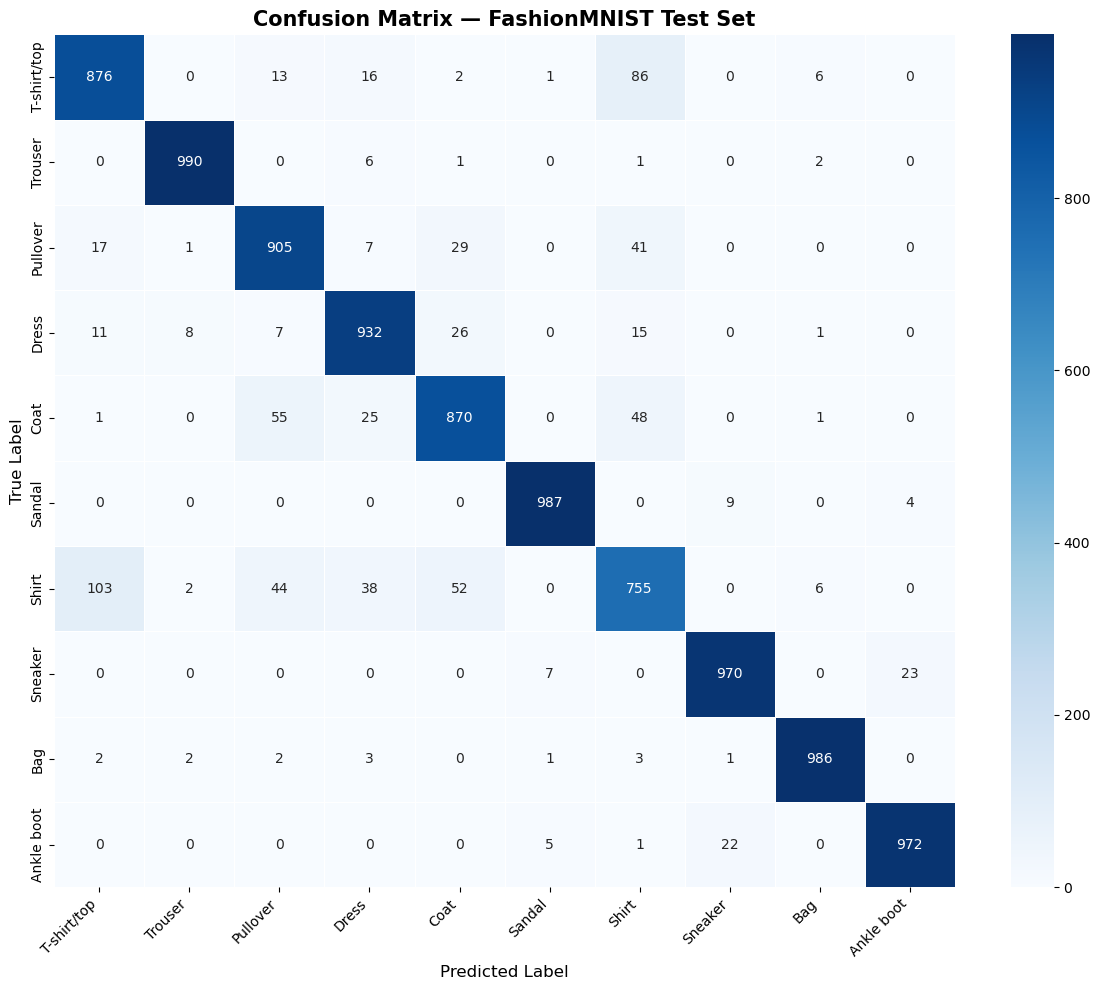

In [9]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    linewidths=0.5
)
plt.title('Confusion Matrix — FashionMNIST Test Set', fontsize=15, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 9. Misclassified Examples

Total misclassified: 757 / 10000 (7.57%)


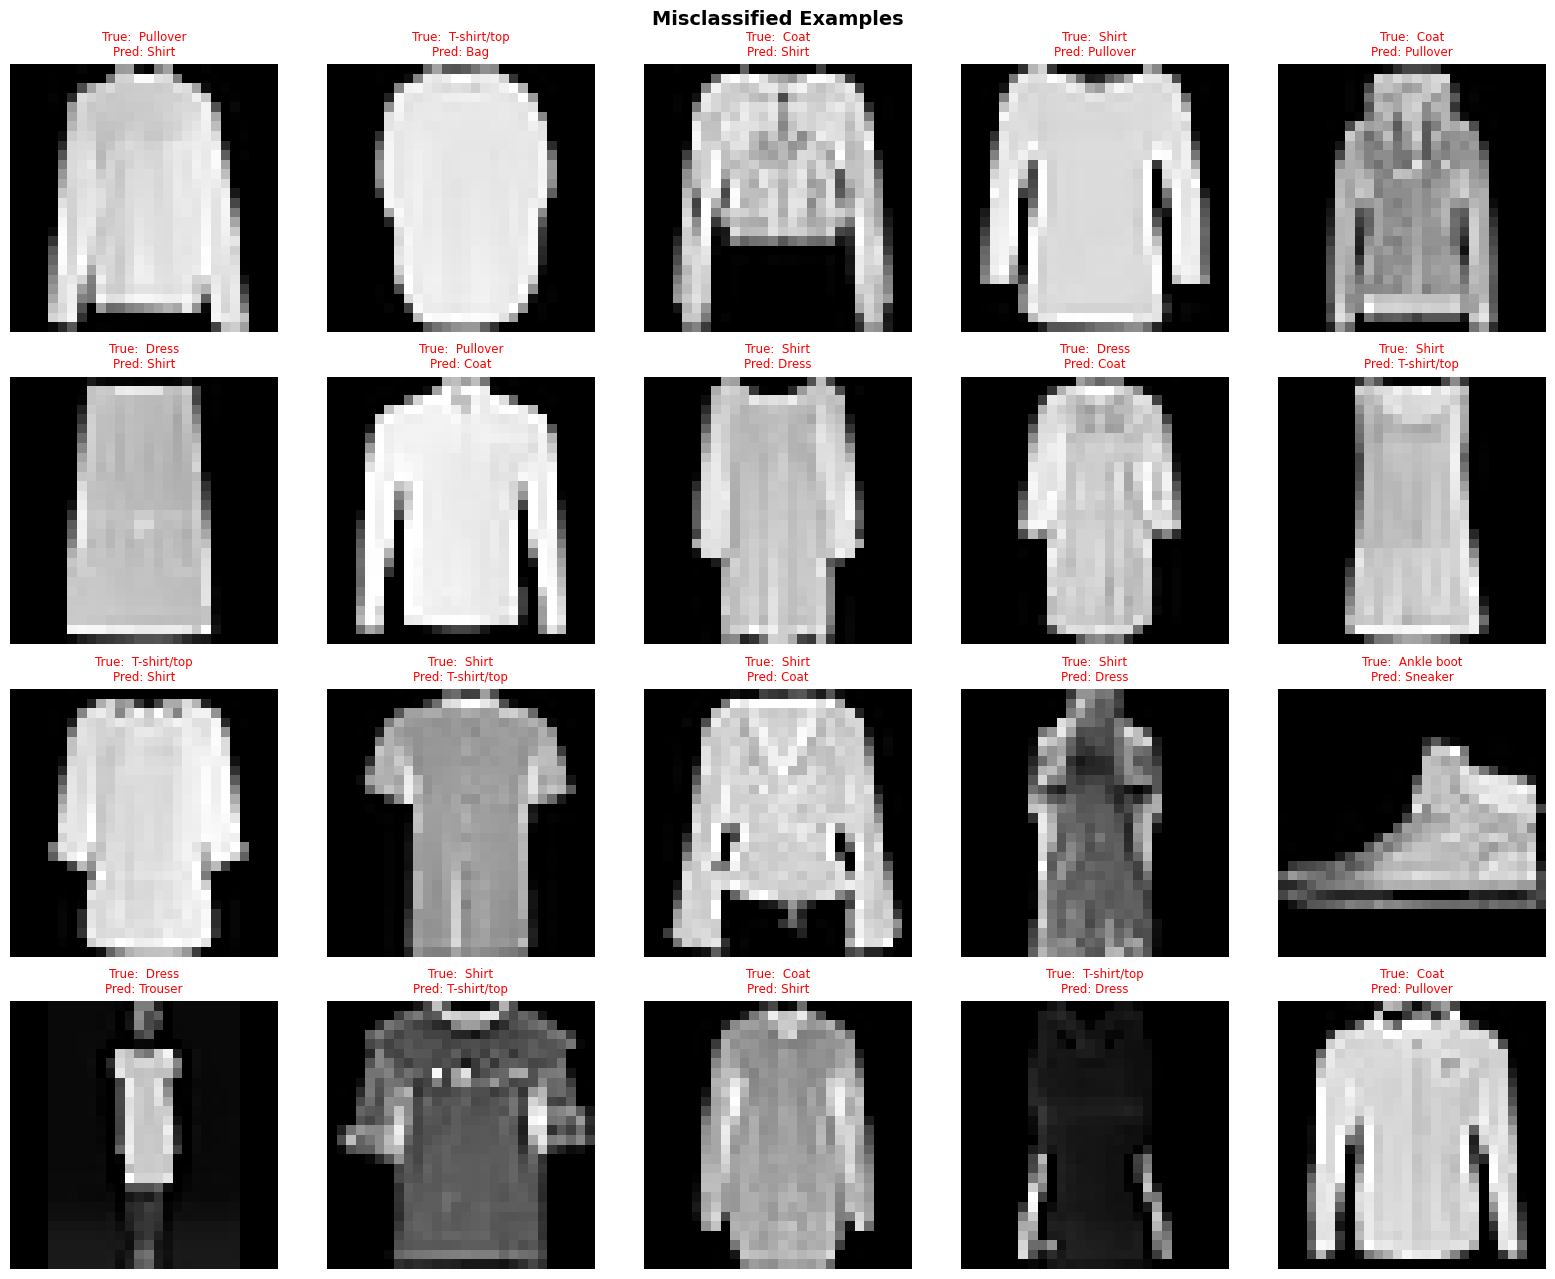

In [10]:
wrong_idx = np.where(all_preds != all_labels)[0]
print(f'Total misclassified: {len(wrong_idx)} / {len(all_labels)} ({len(wrong_idx)/len(all_labels)*100:.2f}%)')

sample_idx = np.random.choice(wrong_idx, size=min(20, len(wrong_idx)), replace=False)

raw_test = datasets.FashionMNIST(root='./data', train=False, download=False,
                                   transform=transforms.ToTensor())

fig, axes = plt.subplots(4, 5, figsize=(16, 13))
for ax, idx in zip(axes.flat, sample_idx):
    img, _ = raw_test[idx]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(
        f'True:  {CLASS_NAMES[all_labels[idx]]}\nPred: {CLASS_NAMES[all_preds[idx]]}',
        fontsize=8.5, color='red'
    )
    ax.axis('off')

plt.suptitle('Misclassified Examples', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Visualize Learned Filters (Conv Block 1)

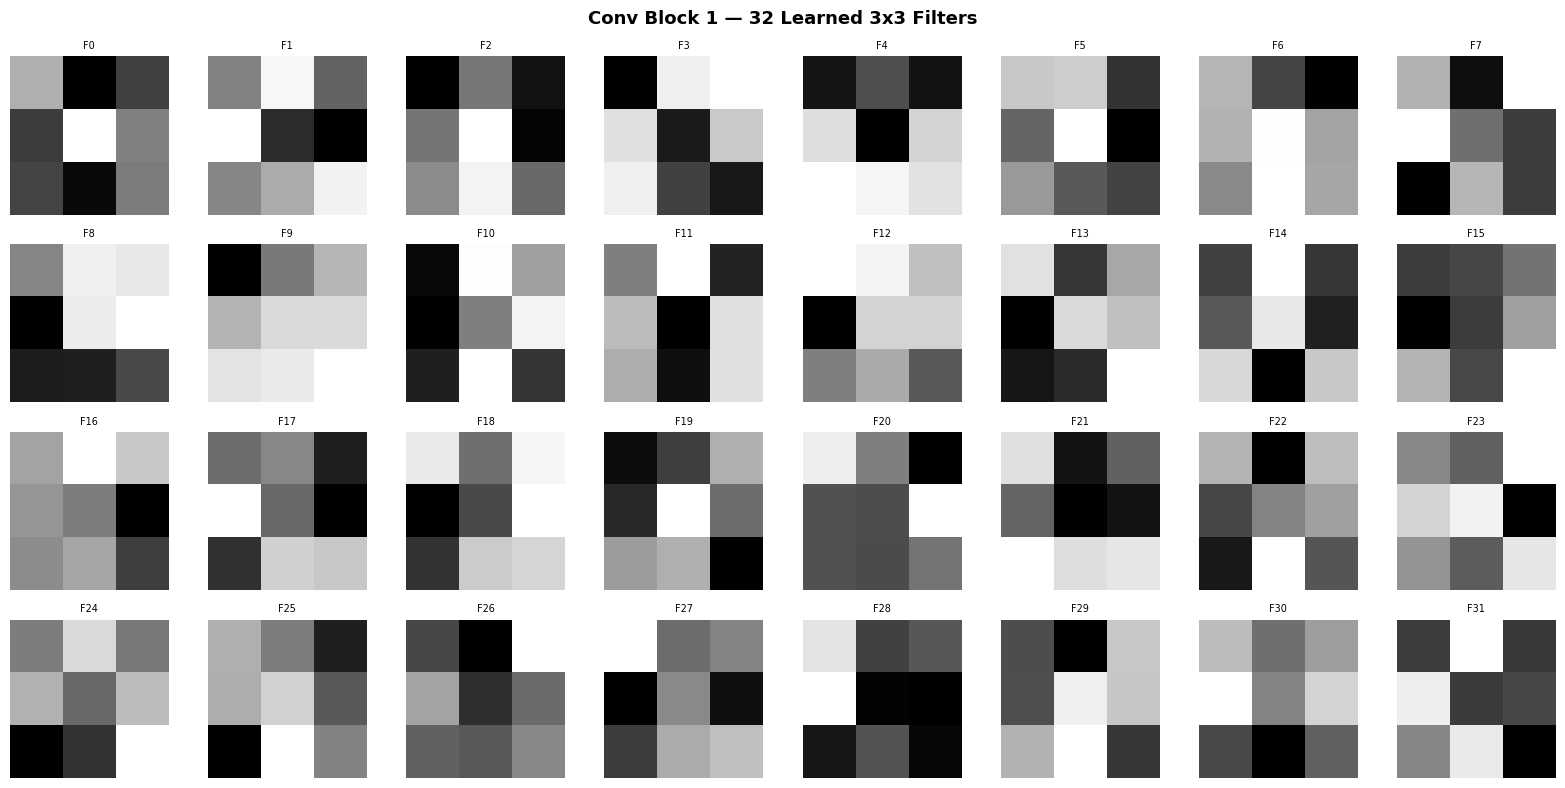

In [11]:
# Shape: (32, 1, 3, 3)
filters = model.conv_block1[0].weight.data.cpu()

# Normalize to [0, 1] for display
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(filters[i, 0], cmap='gray', interpolation='nearest')
    ax.set_title(f'F{i}', fontsize=7)
    ax.axis('off')

plt.suptitle('Conv Block 1 — 32 Learned 3x3 Filters', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 11. Feature Maps for a Single Image

### Analysis — Learned Filters (Conv Block 1)

The 32 filters learned by the first convolutional layer reveal the low-level visual primitives the network built its representations from. Even though no prior knowledge was given about what clothing looks like, three recurring structures emerged from training alone.

**Edge detectors** are the dominant pattern. Filters like F2, F4, F19, and F22 show a sharp dark-to-light or light-to-dark transition across the 3×3 kernel — the classic signature of an edge detector. Some are oriented horizontally, others diagonally. When these filters slide across a garment image, they fire strongly wherever there is a boundary: the outline of a shoe, the collar of a shirt, the strap of a bag.

**Gradient and corner detectors** appear in filters like F0, F8, and F16, which show smooth intensity ramps or asymmetric patterns. These respond to regions where brightness changes gradually across a surface — useful for detecting the curved contours common in clothing silhouettes.

**Texture and spot detectors** like F3, F10, and F11 show more complex high-contrast arrangements. F10 in particular — bright center, dark surround — is a classic center-surround filter that responds to isolated bright regions, similar to a blob detector.

This is consistent with a well-established result in CNN interpretability: regardless of the dataset or task, the first convolutional layer reliably learns edge and texture primitives. The network did not need to be told what features matter — it discovered that edges and local contrasts are the most informative low-level signals for distinguishing clothing categories.

Deeper layers (Conv Block 2) combine these primitives into higher-order representations — sleeve shapes, sole patterns, bag handles — but those filters operate on 32-channel feature maps rather than raw pixels, making direct visual interpretation no longer meaningful.

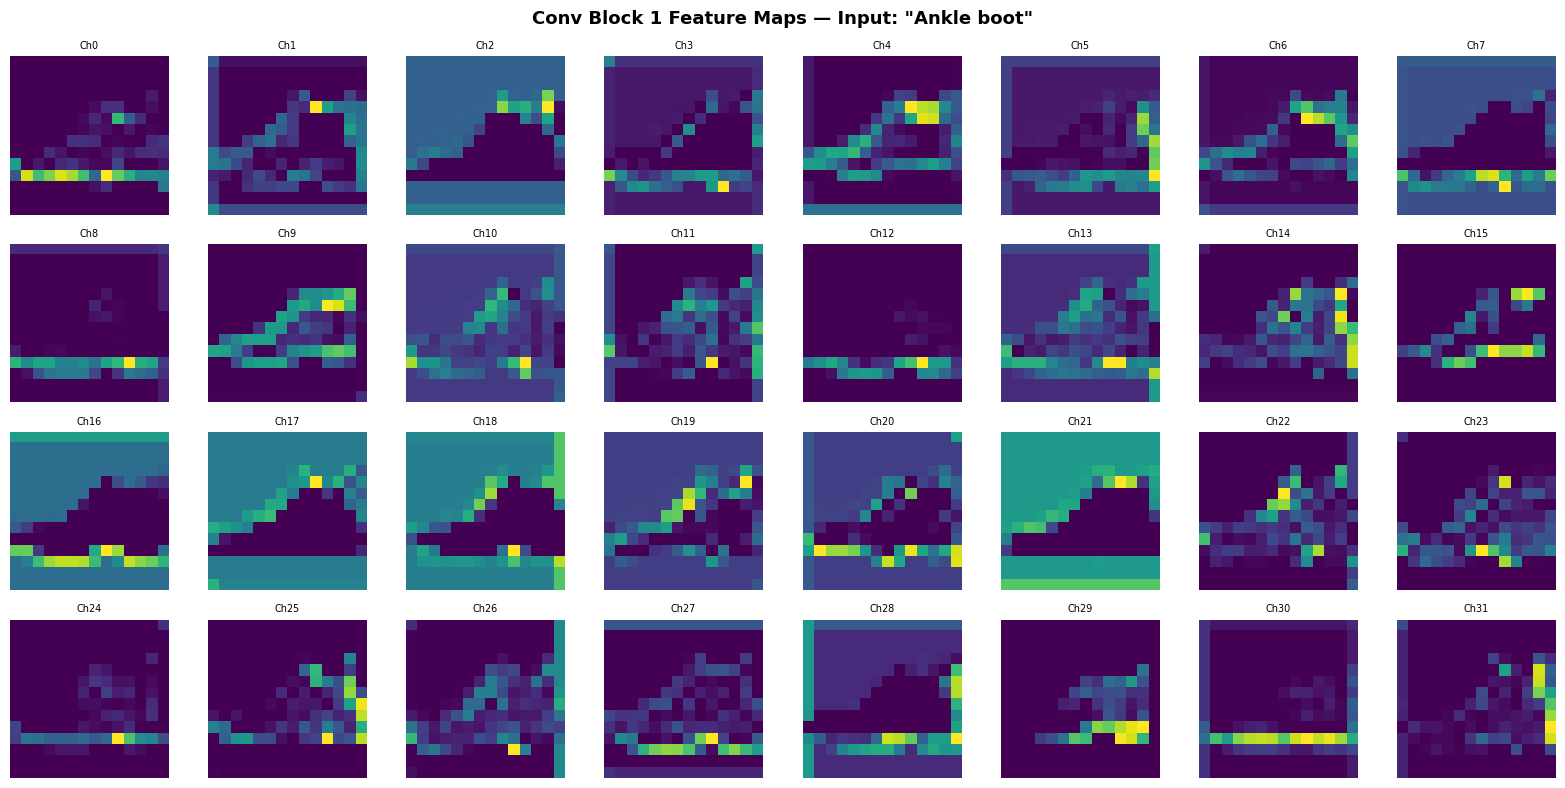

In [12]:
sample_img, sample_label = test_set[0]
sample_tensor = sample_img.unsqueeze(0).to(device)  # (1, 1, 28, 28)

feature_maps = {}

def hook_fn(name):
    def fn(module, input, output):
        feature_maps[name] = output.detach().cpu()
    return fn

h1 = model.conv_block1.register_forward_hook(hook_fn('block1'))
h2 = model.conv_block2.register_forward_hook(hook_fn('block2'))

model.eval()
with torch.no_grad():
    _ = model(sample_tensor)

h1.remove(); h2.remove()

# Block 1 feature maps: (32, 14, 14)
fmaps = feature_maps['block1'].squeeze(0)

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(fmaps[i], cmap='viridis')
    ax.set_title(f'Ch{i}', fontsize=7)
    ax.axis('off')

plt.suptitle(
    f'Conv Block 1 Feature Maps — Input: "{CLASS_NAMES[sample_label]}"',
    fontsize=13, fontweight='bold'
)
plt.tight_layout()
plt.show()

### Analysis — Conv Block 1 Feature Maps (Ankle Boot)

Each of the 32 maps shows what a specific filter responded to after scanning the input image. The color scale runs from **purple** (no activation) to **yellow** (strong activation) — so bright regions indicate where each filter detected its target pattern.

**The sole** — the bright yellow horizontal band at the bottom of Ch0, Ch8, Ch16, and Ch20 is the flat sole of the boot. Those filters learned to fire on horizontal edges, and the sole/ground boundary is the strongest horizontal edge in the image.

**The silhouette outline** — Ch1, Ch2, Ch9, Ch17, Ch18, and Ch21 all show the boot's curved profile lit up along the top and sides. These are edge detectors tracing the boot's contour.

**The toe cap** — the bright spot in the bottom-right corner of Ch3, Ch10, and Ch29 corresponds to the corner where the toe meets the sole — a strong diagonal edge.

**Ch21** is particularly interesting — mostly teal and uniformly activated across the whole boot shape, meaning that filter responds to the boot as a filled region rather than just its boundaries. It detects the object's bulk, not its edges.

**Ch8 and Ch12** are almost entirely dark — those filters found nothing relevant in an ankle boot. They are likely specialized for textures or shapes more common in other classes like shirts or bags.

The network never sees the boot as a whole — it decomposes it into 32 partial descriptions simultaneously, and the classifier then combines them to reach a prediction.